In [126]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
def f(x):
    return 3*x**2 - 4*x +5

In [128]:
f(3.0)

20.0

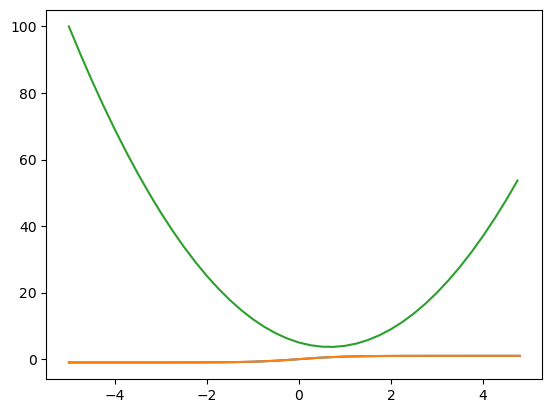

In [129]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)
plt.show() 

In [130]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [131]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [425]:
class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        # for n in self._prev:
        #     print (f"adding prev child {n.label} for {self.data}")
        self._op = _op
        self.label = label
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) +1)
        out = Value(t, (self,) , 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        x = self.data
        n = other
        out = Value(x**n, (self,), f'pow{other}')
        def _backward():
            self.grad += n * (x**(n-1)) * out.grad
        out._backward = _backward
        return out
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self*other
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return other  + (-self)
    def __truediv__(self, other): # self / other
        return self * other**-1
    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def backward(self):
        # need to be the last node
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            # print(node)

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
# d = (a.__mul__(b)).__add__(c)
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
print(d)

Value(data=4.0, label=d)


In [133]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [134]:
d._op

'+'

In [323]:
from graphviz import Digraph
from collections.abc import Iterable
def trace(root):
    """
    builds a set of all nodes and edges in a graph
    """
    nodes, edges = set(), set()
    # def build(v):
    #     if v not in nodes:
    #         nodes.add(v)
    #         for child in v._prev:
    #             edges.add((child, v))
    #             build(child)
    def build(v):
        # If v is a collection (but not a Value), recurse into items
        if isinstance(v, Iterable) and not hasattr(v, "_prev"):
            for item in v:
                build(item)
            return

        if v not in nodes:
            nodes.add(v)
            for child in getattr(v, "_prev", []):
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph,create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

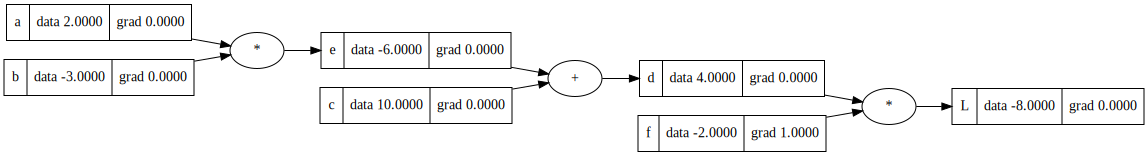

In [324]:
draw_dot(L)

In [ ]:
# L = d* f
# dL/dd = ? f
# (f(x+h) - f(x))/h
# ((d+h)*f - d*f)/h
# (d*f + h*f - d*f)/h
# (h*f)/h
# f

In [137]:
L.grad = 1.0
d.grad = -2
f.grad = 4

In [ ]:
# dL / de
# dL / dd  * dd/de

In [138]:
e.grad = -2
c.grad = -2

In [140]:
# dL/da = dL/de * de/da = -2 * -3
# dL/db = dL/de * de/db = -2 * 2

In [145]:
a.grad = -2*-3
b.grad = -2*2

In [243]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    # d = (a.__mul__(b)).__add__(c)
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0+h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    # d = (a.__mul__(b)).__add__(c)
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

adding child {n.label}
adding child {n.label}
adding child {n.label}
adding child {n.label}
adding child {n.label}
adding child {n.label}
adding child {n.label}
adding child {n.label}
adding child {n.label}
adding child {n.label}
adding child {n.label}
adding child {n.label}
6.000000000000227


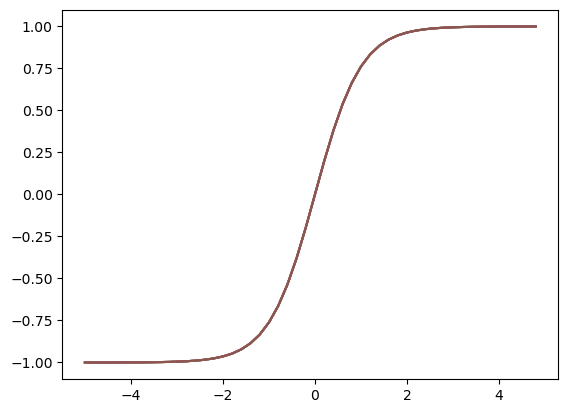

In [160]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.plot(); plt.show() # inputs x1,x2

In [147]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b;
d = e + c;
L = d * f

print(L.data)

-46.97032704860435


In [202]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1, w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.8813735870195432,label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label ='x1w1'
x2w2 = x2*w2; x2w2.label ='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2+b; n.label='n'
o = n.tanh() 
o.label = 'o'

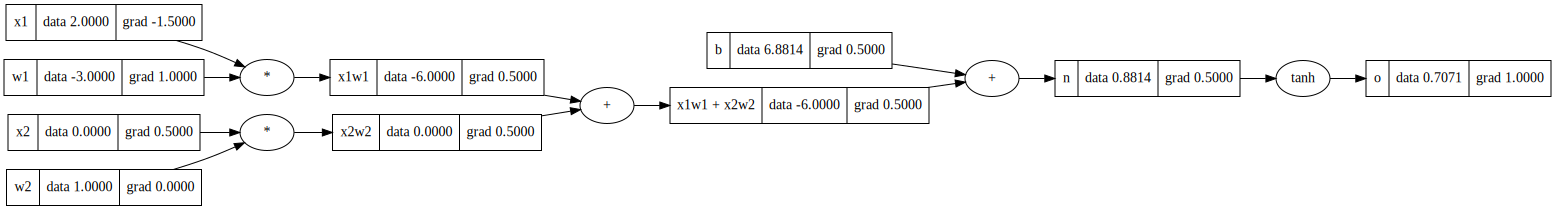

In [205]:
draw_dot(o)

In [204]:
o.grad = 1
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node._backward()
    print(node)

Value(data=0.7071067811865476)
Value(data=0.8813735870195432)
Value(data=-6.0)
Value(data=-6.0)
Value(data=2.0)
Value(data=-3.0)
Value(data=0.0)
Value(data=1.0)
Value(data=0.0)
Value(data=6.881373587019543)


In [195]:
o.grad = 1
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [169]:
w2.grad = x2.data*x2w2.grad
x2.grad = w2.data*x2w2.grad
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

In [166]:
x2w2.grad = 0.5
x1w1.grad = 0.5

In [164]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [165]:
n.grad = 0.5

In [153]:
o.grad = 1.0

In [ ]:
# o = tanh(n)
# do / dn = 1 - o.data**2 = 

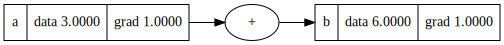

In [207]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.grad = 1
b._backward()
draw_dot(b)

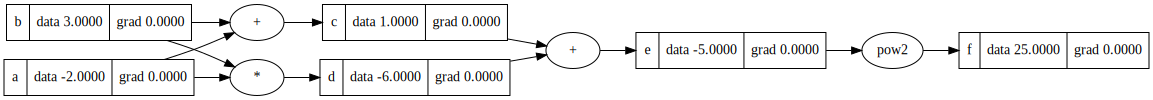

In [272]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a+b; c.label = 'c'
d = a*b; d.label = 'd'
e = c+d; e.label = 'e'
f = e ** 2; f.label = 'f'
draw_dot(f)

In [273]:
f.backward()

Value(data=25.0, label=f)
Value(data=-5.0, label=e)
Value(data=1.0, label=c)
Value(data=-6.0, label=d)
Value(data=-2.0, label=a)
Value(data=3.0, label=b)


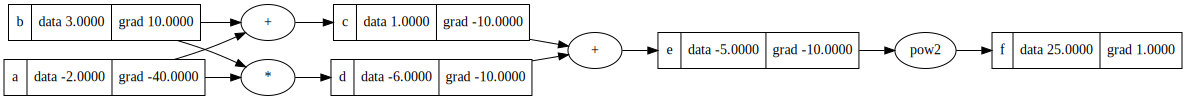

In [274]:
draw_dot(f)

In [285]:
import torch
import random

In [281]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


---
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [279]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [282]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [420]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
    def parameters(self):
        return []
class Neuron(Module):
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x) ), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        # need return out[0] as last layer has 1 neuron
        return out[0] if len(out) == 1 else out
        # return out
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        # return x[0] if len(x) == 1 else x
        return x
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

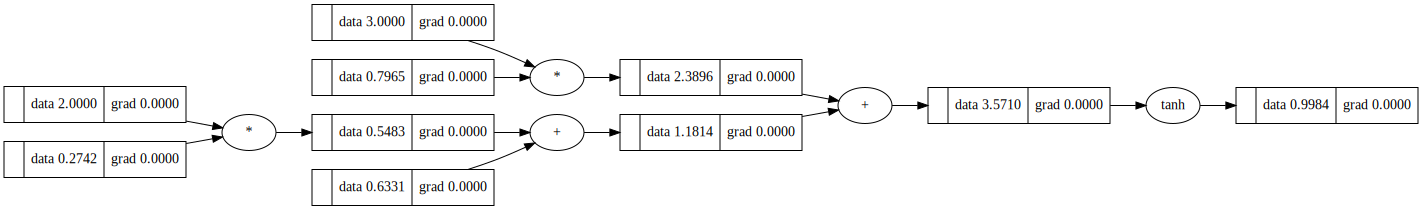

In [346]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)
draw_dot(n(x))

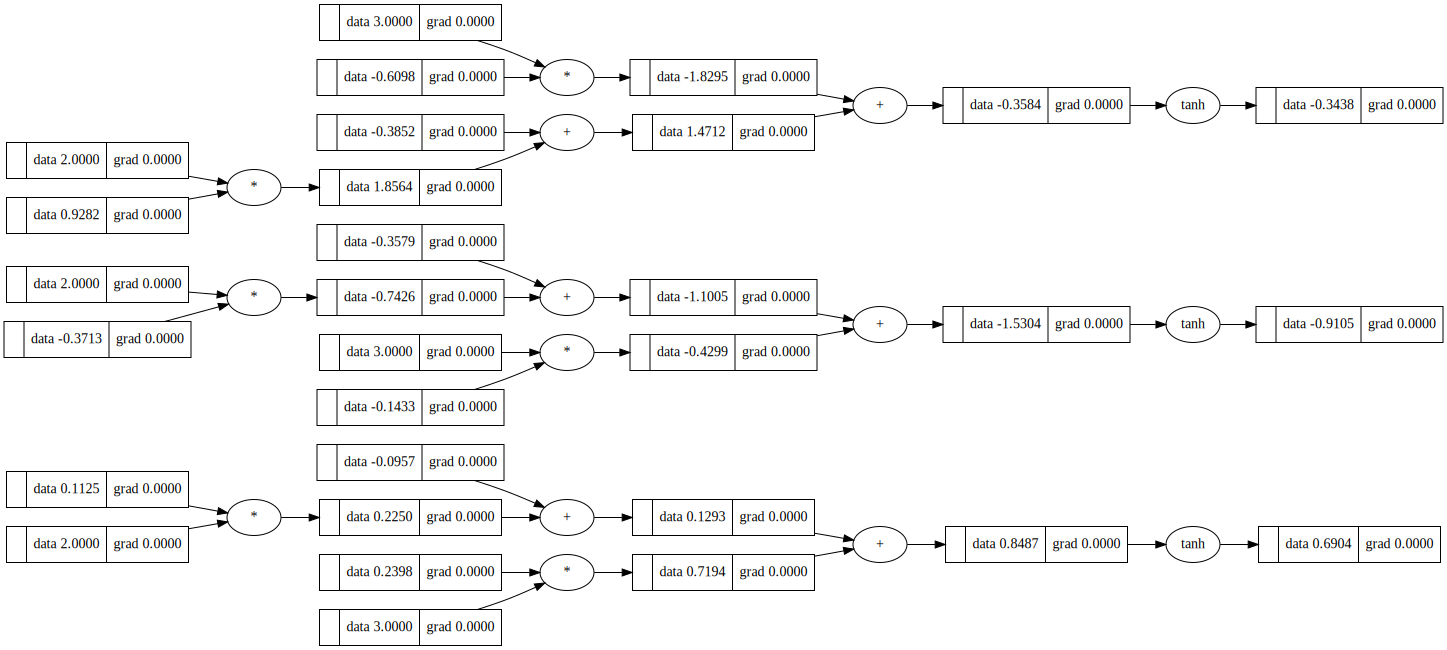

In [349]:
x = [2.0, 3.0]
n = Layer(2,3)
n(x)
draw_dot(n(x))

In [411]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)
len(n.parameters())

41

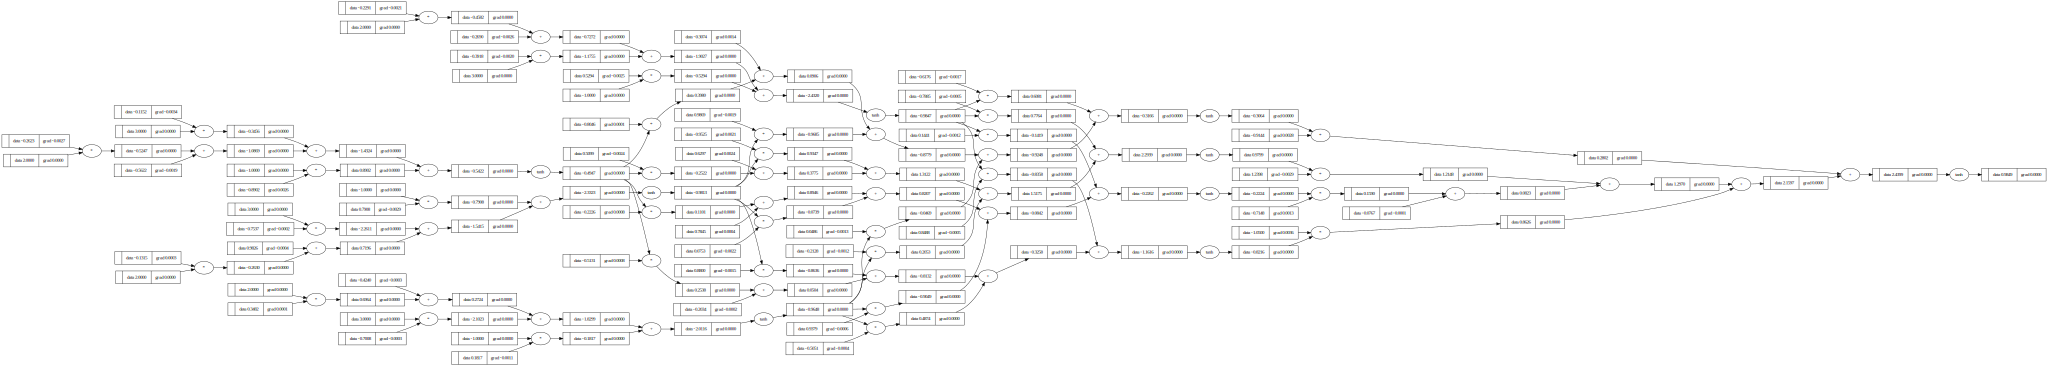

In [435]:
draw_dot(n(x))

In [418]:
xs =[
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

#target values (simple binary classification)
ys =[1.0, -1.0, -1.0, 1.0]

#run the neural network on all the inputs
ypred = [n(x) for x in xs]
ypred

[Value(data=0.14740156285222203, label=),
 Value(data=-0.4366057831345277, label=),
 Value(data=-0.29572540881383735, label=),
 Value(data=0.025132010394586107, label=)]

In [419]:
ypred = [n(x) for x in xs]
loss = 0
for ygt, yout in zip(ys, ypred):
    loss += (yout - ygt)**2 
print(loss)

Value(data=2.4907074355720304, label=)


In [423]:
def train_MLP(n_iter=20, learning_rate=0.01):
    losses, steps = [], []
    step = 0
    for k in range(n_iter):
        step += 1
        steps.append(step)
        
        # forward pass
        ypred = [n(x) for x in xs]
        
        loss = 0
        for ygt, yout in zip(ys, ypred):
            loss += (yout - ygt)**2 
        total_loss = loss
        losses.append(total_loss.data)

        # backward pass -> reset gradients to zero so as to
        # ensure the actual backward pass accumulates the loss derivatives into the gradients
        for p in n.parameters():
            p.grad = 0.0
        total_loss.backward()

        # update parameters
        for p in n.parameters():
            p.data += -1 * learning_rate * p.grad

        print(k, total_loss.data)
    print(ypred)
    return [steps, losses]

In [433]:
_train_loss = train_MLP(40,0.05);

0 0.0015085035341660179
1 0.0014979585431665297
2 0.0014875579820703452
3 0.0014772989459273496
4 0.0014671786063884897
5 0.0014571942092156895
6 0.0014473430718878184
7 0.0014376225812982768
8 0.0014280301915403724
9 0.0014185634217763635
10 0.0014092198541866986
11 0.0013999971319959403
12 0.001390892957571967
13 0.001381905090595435
14 0.0013730313462964137
15 0.0013642695937554367
16 0.0013556177542661185
17 0.0013470737997569385
18 0.0013386357512695122
19 0.0013303016774911735
20 0.0013220696933396487
21 0.0013139379585974972
22 0.001305904676594507
23 0.0012979680929359966
24 0.0012901264942751498
25 0.0012823782071277267
26 0.001274721596727321
27 0.001267155065919732
28 0.0012596770540947407
29 0.001252286036153918
30 0.0012449805215130386
31 0.0012377590531378172
32 0.0012306202066115239
33 0.0012235625892334859
34 0.0012165848391470536
35 0.0012096856244961439
36 0.0012028636426090853
37 0.0011961176192088968
38 0.0011894463076488836
39 0.0011828484881727121
[Value(data=0.98

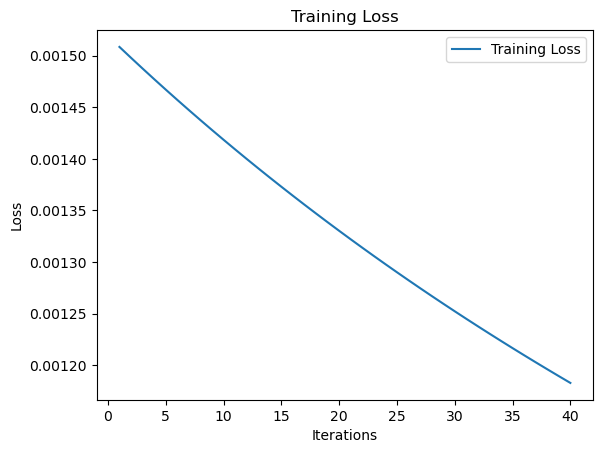

In [434]:
# Retrieve each dictionary's values
train_values = _train_loss[1]
 
# Generate a sequence of integers to represent the iteration numbers
n_iter = _train_loss[0]
 
# Plot and label the training and validation loss values
plt.plot(n_iter, train_values, label='Training Loss')
 
# Add in a title and axes labels
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Set the tick locations
# plt.xticks(np.arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()